In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from datetime import datetime
import pytz

# Download NLTK Ressourcen
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

# Load dataset
df = pd.read_csv("../data/posts_hashtags_selected_columns.csv")

# Convert timestamp column to datetime
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

# Filter to last 6 months
from datetime import datetime
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Keep only rows with non-empty captions
df = df[df["text"].notna()]

# Combine English and German stopwords
stop_words = set(stopwords.words("german")) | set(stopwords.words("english"))

# Clean text and tokenize it
def clean_tokens(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)  # keep only letters
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

# Apply tokenization to all captions
df["tokens"] = df["text"].apply(clean_tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 5 most common words per week

In [47]:
# Add week column
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Explode tokens
df_exploded = df.explode("tokens")

# Calculate top 10 words per week
weekly_words = (
    df_exploded.groupby("week")["tokens"]
    .apply(lambda x: Counter(x).most_common(10))
)

# Reset index to turn week into a column
df_topwords = weekly_words.reset_index()

# Rename for clarity
df_topwords.columns = ["week", "top_words"]

# Explode list of tuples
df_topwords = df_topwords.explode("top_words")

# Split tuple into two columns
df_topwords[["word", "count"]] = pd.DataFrame(df_topwords["top_words"].tolist(), index=df_topwords.index)

# add rank
df_topwords["rank"] = df_topwords.groupby("week").cumcount() + 1

# Final tidy table
df_topwords = df_topwords[["week", "rank", "word", "count"]]

# Sort by newest week
df_topwords = df_topwords.sort_values("week", ascending=False)

# Show it
df_topwords.head(20)

C:\Users\Surface\AppData\Local\Temp\ipykernel_22776\3462156472.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


,week,rank,word,count
23,2025-03-24,10,selfcare,350
23,2025-03-24,9,viral,397
23,2025-03-24,8,glowup,446
23,2025-03-24,7,fyp,460
23,2025-03-24,6,beauty,488
23,2025-03-24,5,skincareroutine,506
23,2025-03-24,4,skin,519
23,2025-03-24,3,hautpflege,837
23,2025-03-24,2,haut,913
23,2025-03-24,1,skincare,978


Most common words by month

In [48]:
# Add 'month' column from timestamp
df["month"] = df["createTimeISO"].dt.to_period("M").dt.start_time

# Explode token column (one word per row)
df_monthly_exploded = df.explode("tokens")

# Count most common words per month (e.g. Top 5)
monthly_words = (
    df_monthly_exploded.groupby("month")["tokens"]
    .apply(lambda x: Counter(x).most_common(5))  # Top 5
)

# Convert to tidy DataFrame
df_monthly = monthly_words.reset_index()
df_monthly.columns = ["month", "top_words"]
df_monthly = df_monthly.explode("top_words")
df_monthly[["word", "count"]] = pd.DataFrame(df_monthly["top_words"].tolist(), index=df_monthly.index)
df_monthly["rank"] = df_monthly.groupby("month").cumcount() + 1
df_monthly = df_monthly[["month", "rank", "word", "count"]]

# Sort by newest month first
df_monthly = df_monthly.sort_values("month", ascending=False)

# Show it
df_monthly.head(30)

C:\Users\Surface\AppData\Local\Temp\ipykernel_22776\3589625581.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["createTimeISO"].dt.to_period("M").dt.start_time


,month,rank,word,count
5,2025-03-01,5,skin,1243
5,2025-03-01,4,beauty,1331
5,2025-03-01,3,skincare,2810
5,2025-03-01,2,hautpflege,2854
5,2025-03-01,1,haut,4351
4,2025-02-01,5,viral,936
4,2025-02-01,4,fyp,1048
4,2025-02-01,3,skincareroutine,1065
4,2025-02-01,2,hautpflege,1142
4,2025-02-01,1,skincare,1256


Wordcloud of most common words for last 6 months

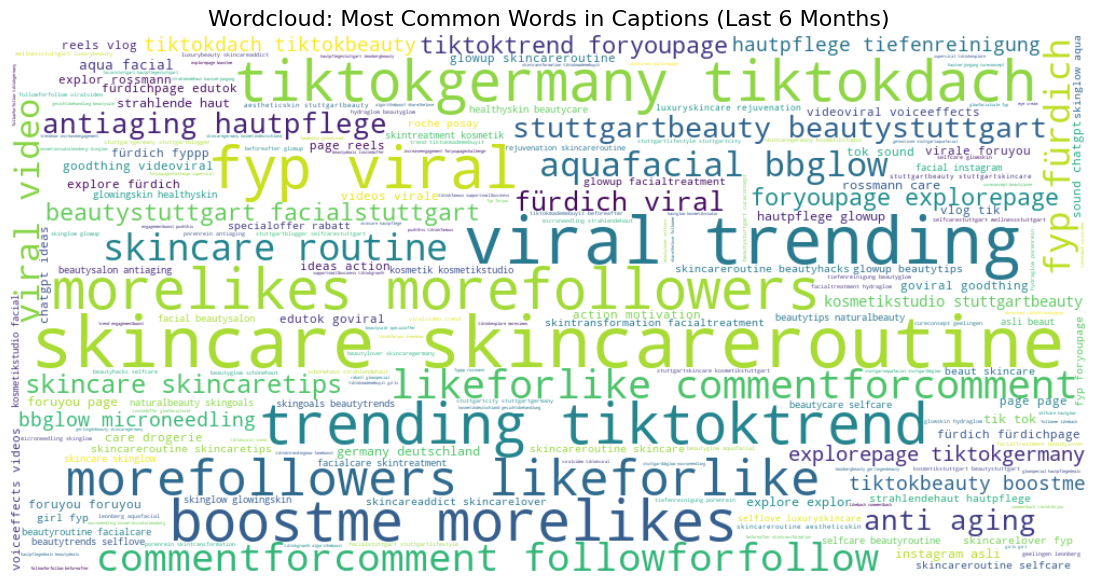

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Alle Tokens aus dem DataFrame (Liste von Listen → flach machen)
all_tokens = df["tokens"].explode().dropna()

# Join all tokens into a single string
text = " ".join(all_tokens)

# Generate wordcloud
wc = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(text)

# Show wordcloud
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud: Most Common Words in Captions (Last 6 Months)", fontsize=16)
plt.show()

Top keyword trends per week (last 6 monts)

In [50]:
from collections import Counter

# Step 1: Create 'week' column from timestamp
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Step 2: Explode token list into one word per row
df_weekly = df.explode("tokens")

# Step 3: Count how often each word appears per week
word_counts = df_weekly.groupby(["week", "tokens"]).size().reset_index(name="count")

# Step 4: Optional - keep only words that occur more than 20 times overall
top_words = word_counts.groupby("tokens")["count"].sum()
top_words = top_words[top_words > 20].index  # adjust threshold if needed

# Step 5: Filter word_counts to keep only top words
filtered = word_counts[word_counts["tokens"].isin(top_words)]

# Step 6: Create pivot table (words as rows, weeks as columns)
pivot_weekly = filtered.pivot_table(
    index="tokens", columns="week", values="count", fill_value=0
)

# Step 7: Sort by total mentions across all weeks (optional)
pivot_weekly["total"] = pivot_weekly.sum(axis=1)
pivot_weekly = pivot_weekly.sort_values("total", ascending=False).drop(columns="total")

# Step 8: Count number of posts per week (not exploded)
weekly_post_counts = df.groupby("week").size()

# Step 9: Convert to DataFrame row and label it
weekly_post_counts = pd.DataFrame([weekly_post_counts])
weekly_post_counts.index = ["total_posts"]

# Step 10: Combine with pivot table (add total_posts as first row)
pivot_with_totals = pd.concat([weekly_post_counts, pivot_weekly])

# Step 11: Display top 15 words (+ total_posts)
pivot_with_totals.head(16)

C:\Users\Surface\AppData\Local\Temp\ipykernel_22776\1645473191.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


week,2024-10-14,2024-10-21,2024-10-28,2024-11-04,2024-11-11,2024-11-18,2024-11-25,2024-12-02,2024-12-09,2024-12-16,...,2025-01-20,2025-01-27,2025-02-03,2025-02-10,2025-02-17,2025-02-24,2025-03-03,2025-03-10,2025-03-17,2025-03-24
total_posts,34.0,78.0,92.0,101.0,126.0,124.0,238.0,151.0,176.0,184.0,...,305.0,152.0,138.0,428.0,921.0,424.0,863.0,976.0,1290.0,1293.0
skincare,20.0,54.0,72.0,83.0,76.0,176.0,356.0,114.0,100.0,180.0,...,224.0,93.0,85.0,228.0,545.0,423.0,527.0,593.0,674.0,978.0
haut,0.0,0.0,33.0,45.0,0.0,7.0,37.0,19.0,61.0,7.0,...,89.0,107.0,0.0,73.0,638.0,38.0,991.0,954.0,1455.0,913.0
hautpflege,0.0,0.0,53.0,30.0,17.0,0.0,63.0,33.0,7.0,13.0,...,73.0,83.0,12.0,120.0,990.0,58.0,687.0,648.0,643.0,837.0
skincareroutine,11.0,38.0,51.0,22.0,28.0,88.0,76.0,65.0,52.0,96.0,...,371.0,6.0,39.0,325.0,522.0,232.0,134.0,224.0,285.0,506.0
fyp,11.0,3.0,25.0,58.0,45.0,40.0,65.0,80.0,49.0,54.0,...,173.0,6.0,26.0,96.0,842.0,120.0,104.0,265.0,215.0,460.0
skin,0.0,112.0,11.0,18.0,23.0,33.0,115.0,21.0,42.0,74.0,...,223.0,65.0,45.0,215.0,168.0,114.0,84.0,176.0,440.0,519.0
beauty,0.0,35.0,191.0,15.0,0.0,18.0,37.0,9.0,19.0,79.0,...,14.0,58.0,5.0,43.0,145.0,72.0,291.0,219.0,323.0,488.0
viral,0.0,9.0,18.0,47.0,23.0,40.0,28.0,15.0,62.0,54.0,...,40.0,6.0,16.0,240.0,669.0,29.0,102.0,99.0,258.0,397.0
glowup,0.0,35.0,11.0,0.0,0.0,5.0,0.0,0.0,21.0,7.0,...,0.0,12.0,5.0,94.0,737.0,28.0,292.0,184.0,225.0,446.0


Plot trend for specific keywords

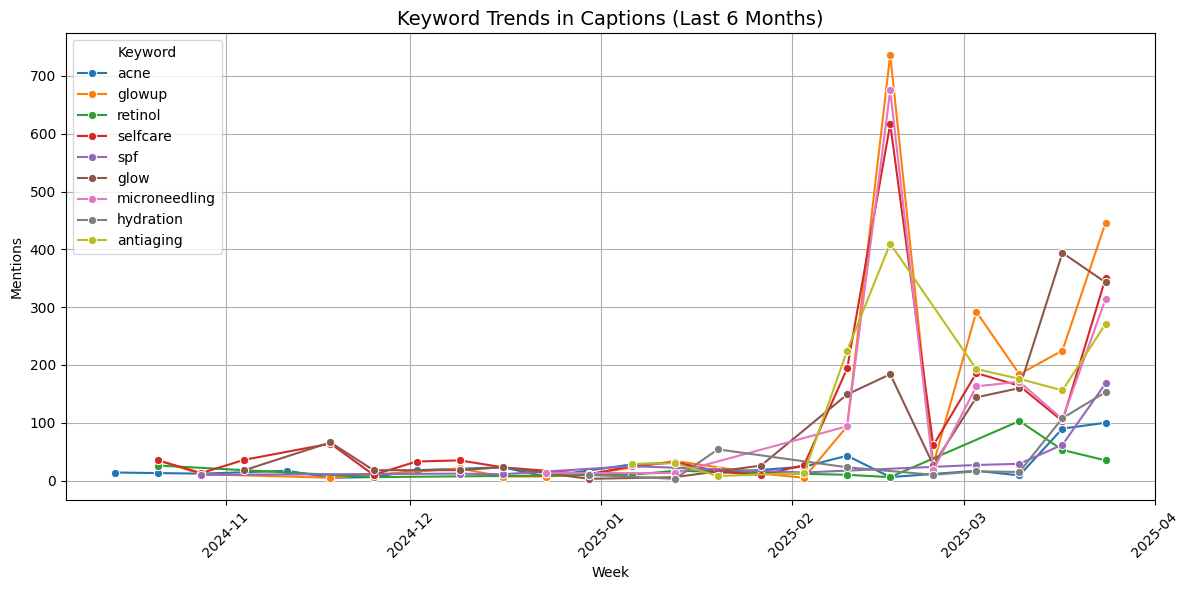

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Track specific keywords
keywords = ["glowup", "selfcare", "microneedling", "antiaging", "spf", "acne", "glow", "retinol", "hydration"]
df_keywords = df_exploded[df_exploded["tokens"].isin(keywords)]

# Group and count
trend_data = (
    df_keywords.groupby(["week", "tokens"])
    .size()
    .reset_index(name="count")
)

# Plot keyword trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x="week", y="count", hue="tokens", marker="o")
plt.title("Keyword Trends in Captions (Last 6 Months)", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Keyword")
plt.show()


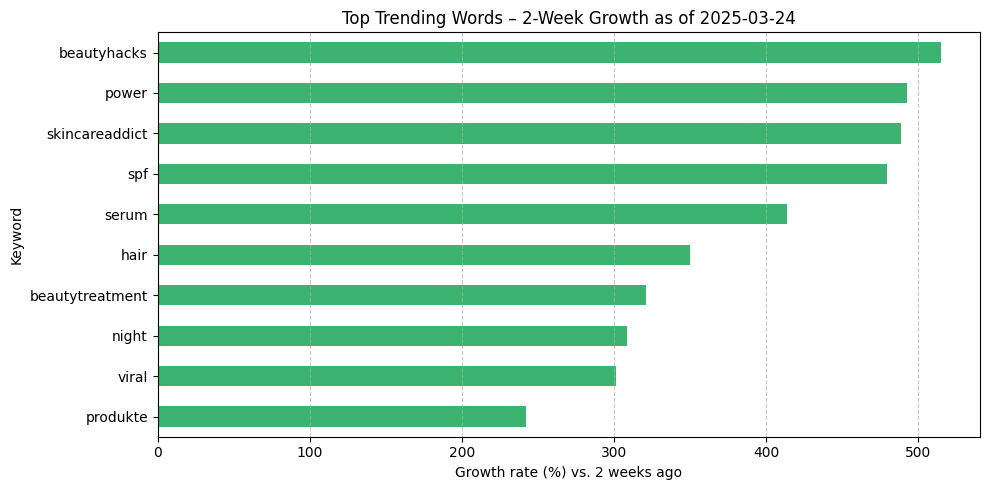

In [52]:
# Get the most recent and the one before that (2 weeks ago)
latest_week = pivot_weekly.columns[-1]
previous_week = pivot_weekly.columns[-3]  # 2 weeks ago

# Calculate percentage growth, avoiding division by zero
previous_counts = pivot_weekly[previous_week].replace(0, 1)
growth_2w = ((pivot_weekly[latest_week] - pivot_weekly[previous_week]) / previous_counts) * 100

# Keep only words that appear at least 50 times in the latest week
min_count = 50
min_previous = 25 # Minimum count in the previous week
valid_words = (pivot_weekly[latest_week] >= min_count) & (pivot_weekly[previous_week] >= min_previous)
trending_2w = growth_2w[valid_words].sort_values(ascending=False)

# Select top 10 trending words
top_trending = trending_2w.head(10)

# Visualize
plt.figure(figsize=(10, 5))
top_trending[::-1].plot(kind="barh", color="mediumseagreen")
plt.title(f"Top Trending Words – 2-Week Growth as of {latest_week.date()}")
plt.xlabel("Growth rate (%) vs. 2 weeks ago")
plt.ylabel("Keyword")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

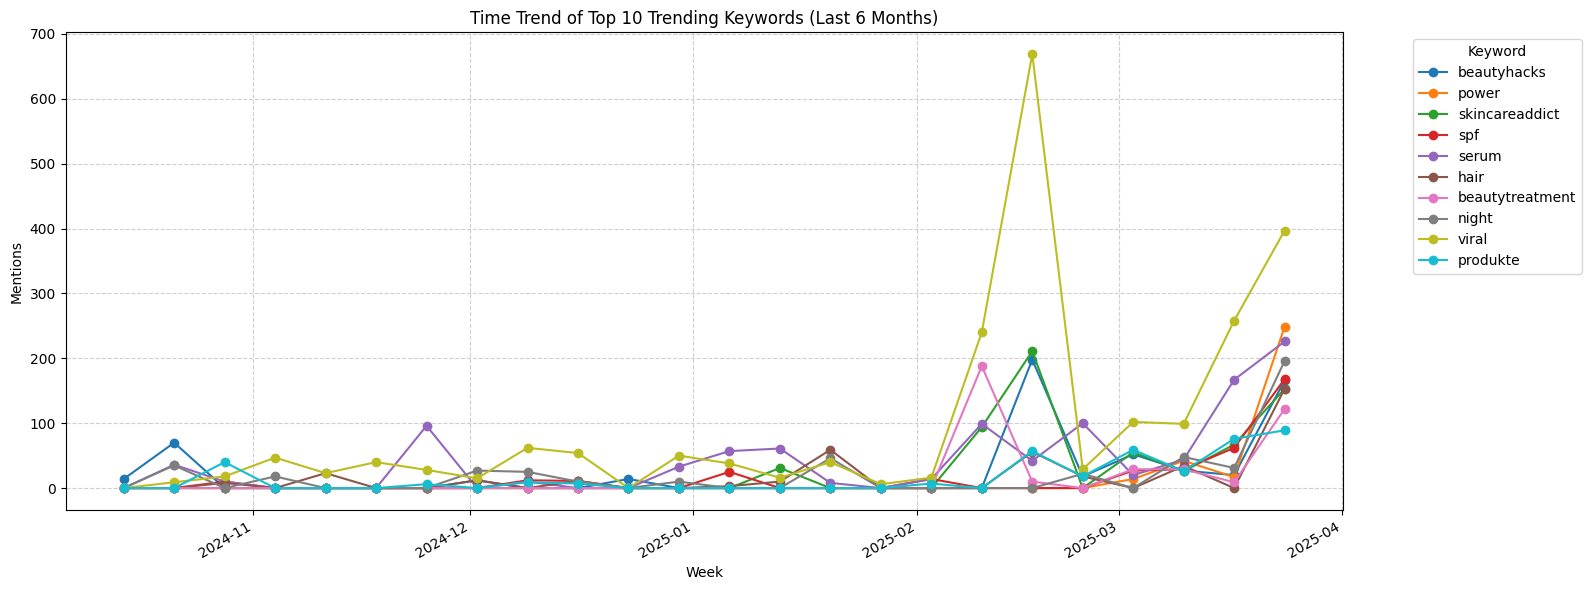

In [54]:
# Number of trending words to show
top_n = 10

# Get the top trending words from 2-week growth analysis
top_trending_words = trending_2w.head(top_n).index.tolist()

# Filter the pivot table to include only those trending words
pivot_trending = pivot_weekly.loc[top_trending_words]

# Transpose for plotting (weeks on the x-axis)
pivot_trending = pivot_trending.T

# Plot the time trend of the top trending words
plt.figure(figsize=(16, 6))  # wider plot
pivot_trending.plot(marker='o', figsize=(16, 6))
plt.title(f"Time Trend of Top {top_n} Trending Keywords (Last 6 Months)")
plt.xlabel("Week")
plt.ylabel("Mentions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()